<a href="https://colab.research.google.com/github/PUBPOL-2130/notebooks/blob/main/future/Week9-draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
%config InlineBackend.figure_formats = ["retina"]

In [97]:
!pip install -q osmnx descartes scikit-learn

In [98]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.lines as mlines

from tqdm import tqdm
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
from joblib import Parallel, delayed

ox.__version__

'2.0.1'

# Cities and Transit
This week's notebook will be focused on cities and transit. We'll focus on a variety of transit-related datasets from the [NYC](https://data.cityofnewyork.us/browse?sortBy=relevance&pageSize=20&category=Transportation&page=1) Open Data Portal (comparatively, you can also check out the [NY State](https://data.ny.gov/browse?category=Transportation&utf8=%E2%9C%93&sortBy=relevance&page=1&pageSize=20) Open Data Portal). Explore these sites on your own as inspiration for your final projects!

A lot of transportation data can be visualized using networks and flow maps, similar to previous weeks. For example, we can examine [Yellow Taxi Trips](https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data) between pairs of NYC neighborhoods or look at [MTA daily ridership](https://data.ny.gov/Transportation/MTA-Daily-Ridership-Data-2020-2025/vxuj-8kew/about_data) between stations.

However, *measuring distance* is another kind of question that's useful to study in the context of transportation --- relevant to questions like:
* how many subway stations are located within 10 minutes of a park?
* how does voter access to a poll site vary by neighborhood?

While conventional straight-line distance measurements may provide approximate answers to these questions, a better and more realistic approach involves analyzing cities via the *street network*.

In this notebook, we'll discuss open-source approaches to calculating *network distances*, which are distances measured along a network (e.g., a street network). We'll also learn how to make an [isochrone map](https://en.wikipedia.org/wiki/Isochrone_map), which is a type of map that depicts all the area accessible within a given travel time.

In [99]:
subway_stations = gpd.read_file('https://data.ny.gov/resource/39hk-dx4f.geojson?$limit=100000')
subway_stations.head()

station_id north_direction_label     line daytime_routes complex_id  \
0          1             Last Stop  Astoria            N W          1   
1          2               Astoria  Astoria            N W          2   
2          3               Astoria  Astoria            N W          3   
3          4               Astoria  Astoria            N W          4   
4          5               Astoria  Astoria            N W          5   

  division ada_southbound gtfs_stop_id structure ada_notes  \
0      BMT              0          R01  Elevated      None   
1      BMT              1          R03  Elevated      None   
2      BMT              0          R04  Elevated      None   
3      BMT              0          R05  Elevated      None   
4      BMT              0          R06  Elevated      None   

              stop_name gtfs_longitude ada_northbound ada  \
0  Astoria-Ditmars Blvd     -73.912034              0   0   
1          Astoria Blvd     -73.917843              1   1   
2                 30 Av     -73.921479              0   0   
3              Broadway     -73.925508              0   0   
4                 36 Av     -73.929575              0   0   

  south_direction_label    cbd borough gtfs_latitude  \
0             Manhattan  False       Q     40.775036   
1             Manhattan  False       Q     40.770258   
2             Manhattan  False       Q     40.766779   
3             Manhattan  False       Q      40.76182   
4             Manhattan  False       Q     40.756804   

                     geometry  
0  POINT (-73.91203 40.77504)  
1  POINT (-73.91784 40.77026)  
2  POINT (-73.92148 40.76678)  
3  POINT (-73.92551 40.76182)  
4   POINT (-73.92958 40.7568)

In [100]:
parks = gpd.read_file('https://nycopendata.socrata.com/resource/enfh-gkve.geojson?$limit=100000')
parks.head()

jurisdiction mapped zipcode  acres  \
0          DPR   True   10034  0.545   
1          DPR  False   10457  2.213   
2          DPR  False   10460  0.114   
3          DPR  False   11373  6.219   
4          DPR   True   10021  3.312   

                                       location nys_assembly councildistrict  \
0                       Broadway and W. 204 St.           72              10   
1        E 182 St bet. Belmont Av and Croton Av           78              15   
2  Hornaday Pl bet. Crotona Pkwy and Mohegan Av           87              15   
3    Grand Ave., 57 Ave. bet. 74 St. and 80 St.           30              30   
4                 FDR Dr., E 76 St. To E 78 St.           76               5   

          typecategory us_congress                  eapply  ...   gisobjid  \
0  Historic House Park          13    Dyckman House Museum  ...  100003823   
1           Playground          15      Belmont Playground  ...  100004948   
2               Garden          15  Volky Garden & Flowers  ...  100005124   
3       Community Park           6           Elmhurst Park  ...  100000211   
4       Community Park          12           John Jay Park  ...  100004745   

                 signname              address permitparent class nys_senate  \
0    Dyckman House Museum        4901 BROADWAY         M-12  PARK         31   
1      Belmont Playground  670 EAST 182 STREET         X-06  PARK         32   
2  Volky Garden & Flowers   851 HORNADAY PLACE         X-06  PARK         32   
3           Elmhurst Park      78-01 57 AVENUE         Q-04  PARK         12   
4           John Jay Park      76-01 FDR DRIVE         M-08  PARK         28   

  permitdistrict borough  waterfront  \
0           M-12       M         0.0   
1           X-06       X         0.0   
2           X-06       X         0.0   
3           Q-04       Q         0.0   
4           M-08       M         0.0   

                                            geometry  
0  MULTIPOLYGON (((-73.92305 40.86718, -73.92248 ...  
1  MULTIPOLYGON (((-73.88697 40.85004, -73.88724 ...  
2  MULTIPOLYGON (((-73.88234 40.84707, -73.88248 ...  
3  MULTIPOLYGON (((-73.88437 40.72891, -73.8841 4...  
4  MULTIPOLYGON (((-73.94904 40.76901, -73.94851 ...  

[5 rows x 34 columns]

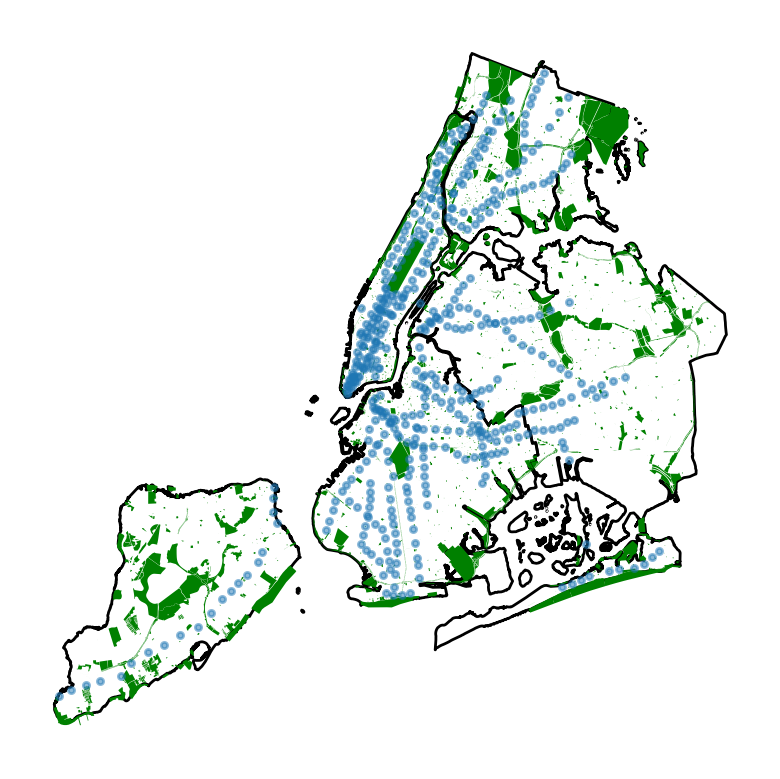

In [101]:
boros = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')
ax = boros.plot(facecolor='none')
parks.plot(ax=ax, facecolor='green')
subway_stations.plot(ax=ax, alpha=0.5, markersize=5)
ax.set_axis_off();

Let's look at how many subway stations are located within 10 minutes of a park *on average*. 10 minutes walking is roughly a half-mile, so we can equivalently examine the average number of parks within 0.5 miles from a park.

A simple way to do this is to create a [buffer](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) in Geopandas, and apply this to the park data. A buffer will return a new geometry containing the original geometry and all the area within a given distance from the original geometry.

First, to specify the correct distance we'll need to make sure that we're in the right projected coordinate system. We'll use [EPSG: 2263](https://spatialreference.org/ref/epsg/2263/), which is a standard projected coordinate system for the NYC area and uses feet as the unit of measurement.

In [102]:
print(parks.crs)
parks_proj = parks.to_crs(2263)
# convert to projected coordinate system!
print(parks_proj.crs)

EPSG:4326
EPSG:2263


In [103]:
# create a buffer of 2640 feet
parks_buffer = parks_proj.copy()
parks_buffer['geometry'] = parks_proj.buffer(2640)

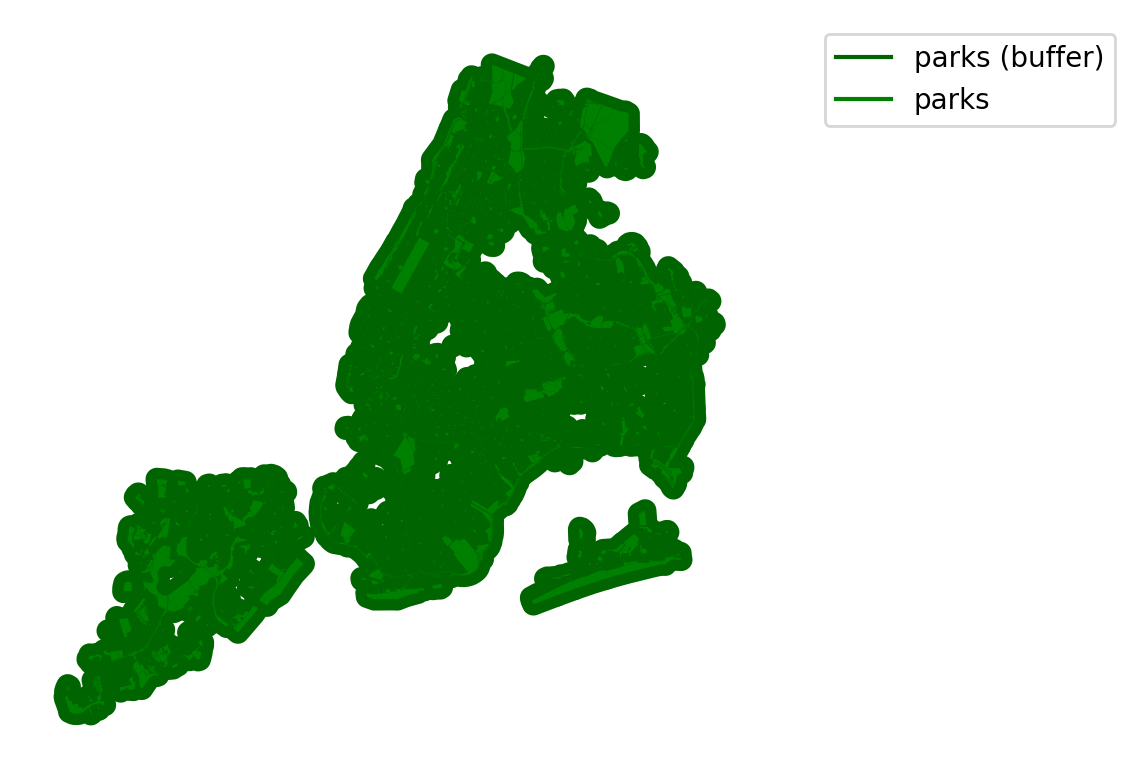

In [104]:
ax = parks_buffer.plot(color='darkgreen')
parks_proj_plot = parks_proj.plot(ax=ax, color='green')

# defining legend style and data
parks_buffer_handle = mlines.Line2D([], [], color='darkgreen', label='parks (buffer)')
parks_handle = mlines.Line2D([], [], color='green', label='parks')

ax.legend(handles=[parks_buffer_handle, parks_handle], loc='upper right', bbox_to_anchor=(1.5, 1))
ax.set_axis_off();

Now, we'll use a [spatial join](https://geopandas.org/en/stable/gallery/spatial_joins.html) to identify the points that intersect the parks buffer. A spatial join works similar to a regular join, but it uses the concept of a spatial intersection or overalp to join the geodataframes rather than an index column.

In [105]:
# check the crs again!
print(subway_stations.crs)
subway_stations = subway_stations.to_crs(2263)
print(subway_stations.crs)

EPSG:4326
EPSG:2263


In [106]:
# dissolve the overlapping polygons
parks_buffer_diss = parks_buffer.dissolve()
# we will use this to see what's not intersecting with our park buffer zone
parks_buffer_diss['10_min_from_park'] = 1

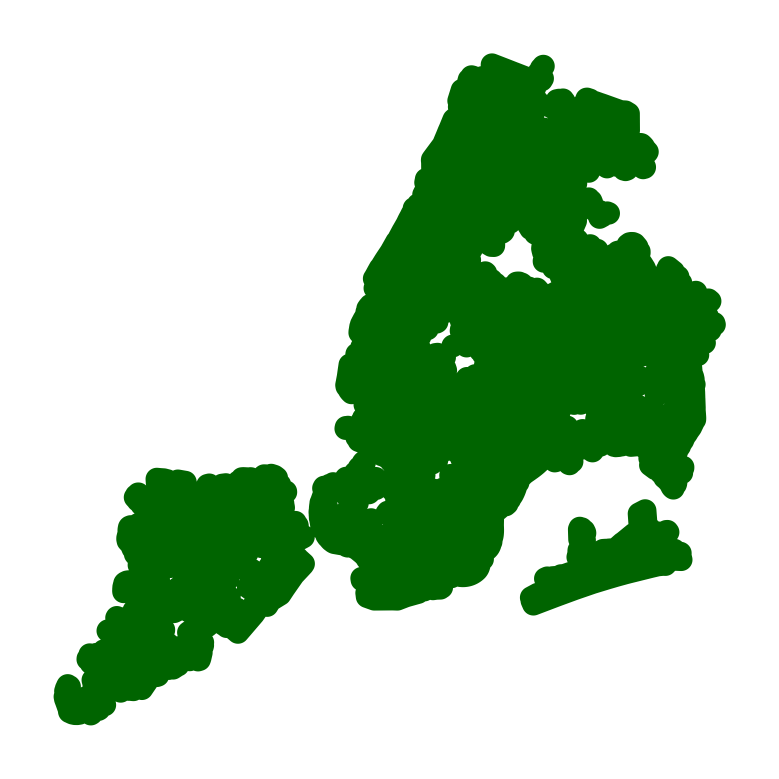

In [107]:
ax = parks_buffer_diss.plot(color='darkgreen')
ax.set_axis_off();

In [108]:
subway_stations_sjoin = subway_stations.sjoin(parks_buffer_diss, how="left")
subway_stations_sjoin.head()

station_id north_direction_label     line daytime_routes complex_id  \
0          1             Last Stop  Astoria            N W          1   
1          2               Astoria  Astoria            N W          2   
2          3               Astoria  Astoria            N W          3   
3          4               Astoria  Astoria            N W          4   
4          5               Astoria  Astoria            N W          5   

  division ada_southbound gtfs_stop_id structure ada_notes  ...   gisobjid  \
0      BMT              0          R01  Elevated      None  ...  100003823   
1      BMT              1          R03  Elevated      None  ...  100003823   
2      BMT              0          R04  Elevated      None  ...  100003823   
3      BMT              0          R05  Elevated      None  ...  100003823   
4      BMT              0          R06  Elevated      None  ...  100003823   

               signname        address permitparent class nys_senate  \
0  Dyckman House Museum  4901 BROADWAY         M-12  PARK         31   
1  Dyckman House Museum  4901 BROADWAY         M-12  PARK         31   
2  Dyckman House Museum  4901 BROADWAY         M-12  PARK         31   
3  Dyckman House Museum  4901 BROADWAY         M-12  PARK         31   
4  Dyckman House Museum  4901 BROADWAY         M-12  PARK         31   

  permitdistrict borough_right waterfront  10_min_from_park  
0           M-12             M        0.0               1.0  
1           M-12             M        0.0               1.0  
2           M-12             M        0.0               1.0  
3           M-12             M        0.0               1.0  
4           M-12             M        0.0               1.0  

[5 rows x 54 columns]

In [109]:
# almost all subway stations are within 10 minutes of a park!
# missing values of our indicator column indicate that it didn't intersect with the park buffer zone
pct_10_min_park = (subway_stations_sjoin['10_min_from_park'].notna().mean()*100)
print(f'{pct_10_min_park.round(2)}% of subway stations are within 10 minutes of a park')

99.8% of subway stations are within 10 minutes of a park


In [110]:
# what is the one subway station that is not within 10 minutes from a park?
subway_stations_sjoin[subway_stations_sjoin['10_min_from_park'].isna()]

station_id north_direction_label        line daytime_routes complex_id  \
195        195             Manhattan  Liberty Av              A        195   

    division ada_southbound gtfs_stop_id structure ada_notes  ... gisobjid  \
195      IND              1          A65  Elevated      None  ...      NaN   

    signname address permitparent class nys_senate permitdistrict  \
195      NaN     NaN          NaN   NaN        NaN            NaN   

    borough_right waterfront  10_min_from_park  
195           NaN        NaN               NaN  

[1 rows x 54 columns]

Creating a buffer assumes that straight-line distance is sufficient. But, realistically, straight-line distance is quite a strong assumption.

Now, we'll try calculating the number of subway stations within 10 minutes from a park but we'll calculate distance along a street network.

## Download the street network

We'll download the street network using OSMnx. OSMnx retrieves the place boundaries of the city from the [Nominatim API](https://nominatim.org/), which uses OpenStreetMap data. It retrieves the street networks via the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) (another API using OpenStreetMap) data. Then, it constructs a graphical model where nodes represent intersections and edges represent streets.

OSMnx leverages [NetworkX](https://networkx.org/documentation/stable/) for constructing graphs, which we've seen in previous notebooks.

It also provides functions for converting between graphs and geodataframes.

In [112]:
# setup, we'll load data for NYC
place = 'New York, NY, USA'
network_type = 'walk' # you can also try bike, and drive
trip_times = [1, 5, 10] # minutes

In [321]:
# download the street network, this may take a few minutes
G = ox.graph_from_place(place, network_type=network_type)

In [322]:
# project the graph
G = ox.project_graph(G, to_crs=2263)

Let's compute some basic stats about the street network. For example, the number of nodes and the average edge length.

In [323]:
stats = ox.stats.basic_stats(G)
stats

{'n': 273521,
 'm': 898146,
 'k_avg': 6.567290994110142,
 'edge_length_total': 42646336.836194076,
 'edge_length_avg': 47.48263293071959,
 'streets_per_node_avg': 3.2843986384957646,
 'streets_per_node_counts': {0: 0,
  1: 31378,
  2: 3,
  3: 102683,
  4: 138475,
  5: 883,
  6: 90,
  7: 8,
  8: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.11471879672858756,
  2: 1.0968079233404382e-05,
  3: 0.37541175997455406,
  4: 0.5062682572818906,
  5: 0.003228271321032023,
  6: 0.0003290423770021315,
  7: 2.924821128907835e-05,
  8: 3.656026411134794e-06},
 'intersection_count': 242143,
 'street_length_total': 21323168.418097038,
 'street_segment_count': 449073,
 'street_length_avg': 47.48263293071959,
 'circuity_avg': 0.3149964594378306,
 'self_loop_proportion': 0.0013717146210081657}

In [324]:
# store the nodes as a geodataframe
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
gdf_nodes.head()

y              x  street_count   highway  ref railway  \
osmid                                                                           
30807314    227359.977982  994335.758324             4       NaN  NaN     NaN   
2057103273  226874.729134  994265.458967             4       NaN  NaN     NaN   
6579409036  227473.933093  994488.505785             3       NaN  NaN     NaN   
4303265016  227339.914966  994363.844744             3       NaN  NaN     NaN   
1203806304  227403.098947  994297.112369             4  crossing  NaN     NaN   

           junction                       geometry  
osmid                                               
30807314        NaN  POINT (994335.758 227359.978)  
2057103273      NaN  POINT (994265.459 226874.729)  
6579409036      NaN  POINT (994488.506 227473.933)  
4303265016      NaN  POINT (994363.845 227339.915)  
1203806304      NaN  POINT (994297.112 227403.099)

In [325]:
# store the edges as a geodataframe
gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True).reset_index()
gdf_edges.head()

u           v  key       osmid    highway  oneway reversed  \
0    30807314  2057103273    0    46613689  bridleway   False    False   
1    30807314  6579409036    0    46613689  bridleway   False     True   
2    30807314  4303265016    0   147089927    footway   False    False   
3    30807314  1203806304    0   147089927    footway   False     True   
4  2057103273  1203806190    0  1081028185    footway   False     True   

       length                                           geometry name  ...  \
0  159.255042  LINESTRING (994335.758 227359.978, 994328.783 ...  NaN  ...   
1   58.144181  LINESTRING (994335.758 227359.978, 994344.672 ...  NaN  ...   
2   10.509449  LINESTRING (994335.758 227359.978, 994349.829 ...  NaN  ...   
3   17.645411  LINESTRING (994335.758 227359.978, 994307.584 ...  NaN  ...   
4   15.480750  LINESTRING (994265.459 226874.729, 994315.639 ...  NaN  ...   

   ref access junction service bridge width tunnel est_width area landuse  
0  NaN    NaN      NaN     NaN    NaN   NaN    NaN       NaN  NaN     NaN  
1  NaN    NaN      NaN     NaN    NaN   NaN    NaN       NaN  NaN     NaN  
2  NaN    NaN      NaN     NaN    NaN   NaN    NaN       NaN  NaN     NaN  
3  NaN    NaN      NaN     NaN    NaN   NaN    NaN       NaN  NaN     NaN  
4  NaN    NaN      NaN     NaN    NaN   NaN    NaN       NaN  NaN     NaN  

[5 rows x 22 columns]

In [326]:
# get the nearest street nodes from the park centroids
park_nodes = ox.nearest_nodes(G, parks_proj.centroid.x, parks_proj.centroid.y)


Another way you could do this is to grab any street that intersects within a 100-foot buffer around the parks:

In [327]:
parks_proj_buffer = parks_proj.copy()
parks_proj_buffer['geometry'] = parks_proj_buffer['geometry'].buffer(100)
gdf_edges_park = gdf_edges.sjoin(parks_proj_buffer)
gdf_edges_park.head()

u           v  key       osmid    highway  oneway reversed  \
0    30807314  2057103273    0    46613689  bridleway   False    False   
1    30807314  6579409036    0    46613689  bridleway   False     True   
2    30807314  4303265016    0   147089927    footway   False    False   
3    30807314  1203806304    0   147089927    footway   False     True   
4  2057103273  1203806190    0  1081028185    footway   False     True   

       length                                           geometry name  ...  \
0  159.255042  LINESTRING (994335.758 227359.978, 994328.783 ...  NaN  ...   
1   58.144181  LINESTRING (994335.758 227359.978, 994344.672 ...  NaN  ...   
2   10.509449  LINESTRING (994335.758 227359.978, 994349.829 ...  NaN  ...   
3   17.645411  LINESTRING (994335.758 227359.978, 994307.584 ...  NaN  ...   
4   15.480750  LINESTRING (994265.459 226874.729, 994315.639 ...  NaN  ...   

  omppropid   gisobjid      signname        address permitparent class  \
0      M010  100004894  Central Park  1000 5 AVENUE         M-13  PARK   
1      M010  100004894  Central Park  1000 5 AVENUE         M-13  PARK   
2      M010  100004894  Central Park  1000 5 AVENUE         M-13  PARK   
3      M010  100004894  Central Park  1000 5 AVENUE         M-13  PARK   
4      M010  100004894  Central Park  1000 5 AVENUE         M-13  PARK   

  nys_senate permitdistrict borough waterfront  
0     283047           M-13       M        0.0  
1     283047           M-13       M        0.0  
2     283047           M-13       M        0.0  
3     283047           M-13       M        0.0  
4     283047           M-13       M        0.0  

[5 rows x 56 columns]

In [328]:
gdf_edges_park.shape

(203594, 56)

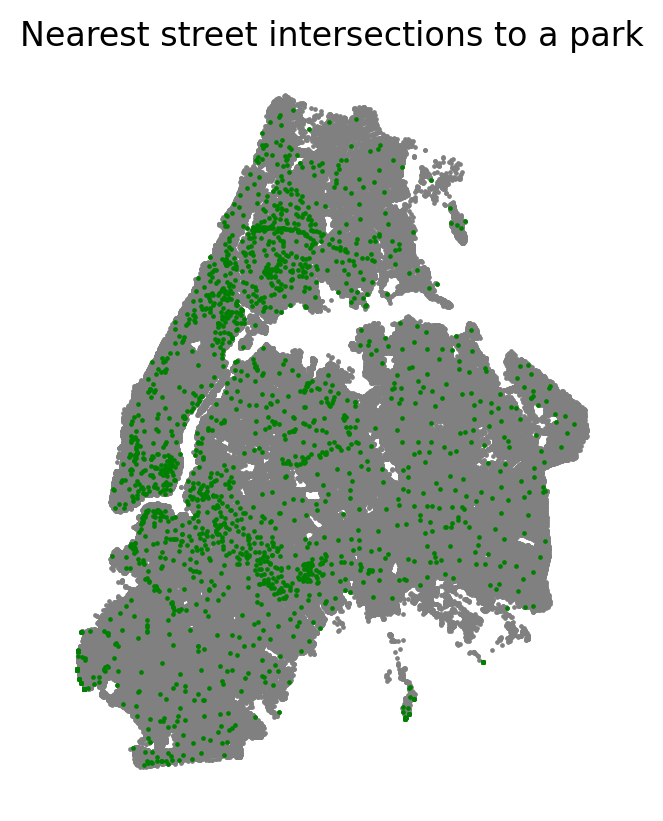

In [329]:
ax = gdf_nodes.plot(color='gray', markersize=0.5)
gdf_nodes.loc[park_nodes].plot(ax=ax, color='green', markersize=0.5)
ax.set_title('Nearest street intersections to a park')
ax.set_axis_off();

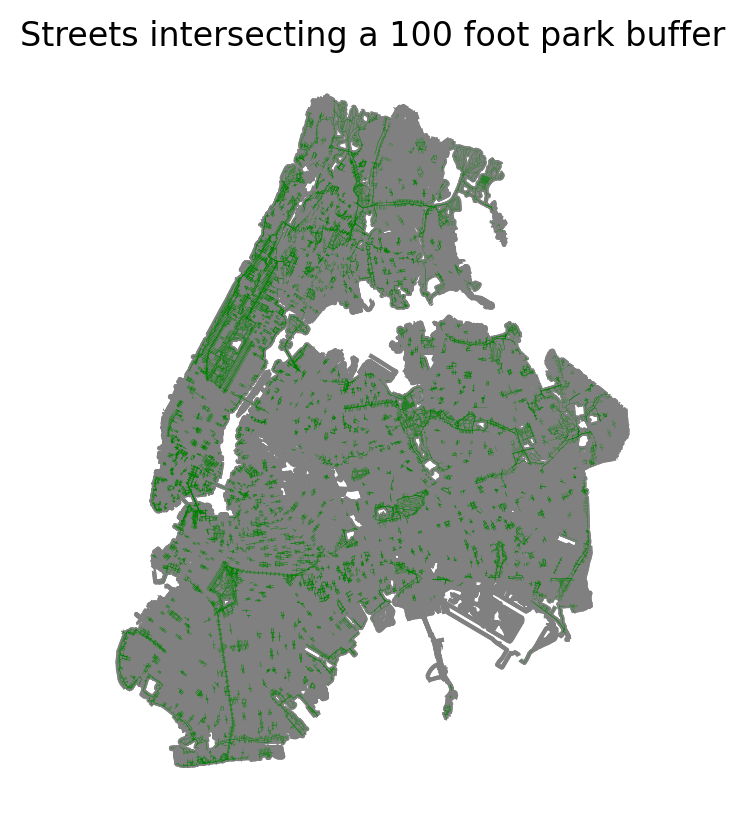

In [330]:
ax = gdf_edges.plot(color='gray', markersize=0.5)
gdf_edges_park.plot(ax=ax, color='green', linewidth=0.05)
ax.set_title('Streets intersecting a 100 foot park buffer')
ax.set_axis_off();

Now, we'll add edge information that estimates the amount of time required to traverse each edge.

In [331]:
avg_feet_per_minute = 276 # you can change this!

for u, v, k, data in G.edges(data=True, keys=True):
    data['length_ft'] = data['length']*3.28084 # osmnx internal units are meters
    data['time'] = data['length_ft'] / (avg_feet_per_minute) # divide by feet per minute

## How far can you walk on foot within each time?

In [332]:
# define colors for each isochrone
iso_colors = ['darkgreen', 'green', 'lightgreen']
iso_colors

# color the nodes according to isochrone then plot the street network
node_colors = {}
for park_node in tqdm(park_nodes):
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G, park_node, radius=trip_time, distance='time')
        for node in subgraph.nodes():
            node_colors[node] = color

100%|██████████| 2052/2052 [00:32<00:00, 63.33it/s] 


Now, we'll plot the street *nodes* that are within 1, 5 and 10 minutes of a park

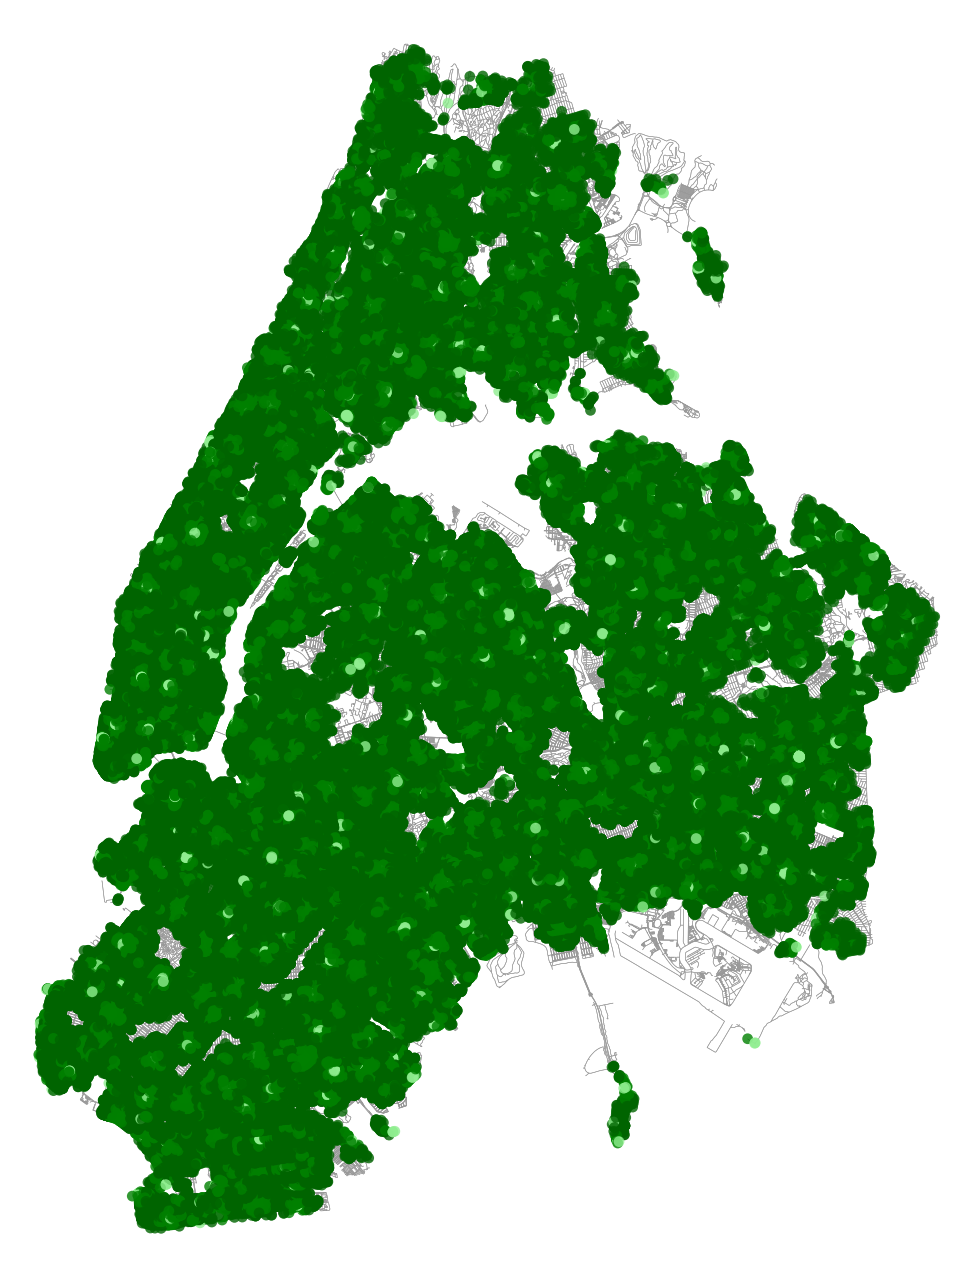

In [333]:
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='w', edge_linewidth=0.2, edge_color='#999999')

## Produce Isochrones

* Approach 1: Distance "as the crow flies"
* Approach 2: Network Distance
    - Modes of visualization:
        - Use convex hull
        - Create a buffer along street edges

Several functions below make use of code originally provided in this [example notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb) on using OSMnx to produce isochrones. The functions have been modified and simplified here to focus on the specific content (i.e., parks and subways).

First, we select a location of interest. In this case, we'll investigate the subway station that was shown to be far away from any nearby parks.

In [335]:
selected_subway_station = subway_stations_sjoin[subway_stations_sjoin['station_id']=='195']
selected_subway_station

station_id north_direction_label        line daytime_routes complex_id  \
195        195             Manhattan  Liberty Av              A        195   

    division ada_southbound gtfs_stop_id structure ada_notes  ... gisobjid  \
195      IND              1          A65  Elevated      None  ...      NaN   

    signname address permitparent class nys_senate permitdistrict  \
195      NaN     NaN          NaN   NaN        NaN            NaN   

    borough_right waterfront  10_min_from_park  
195           NaN        NaN               NaN  

[1 rows x 54 columns]

We'll examine this first using distance "as the crow flies" -- i.e., we'll calculate several buffer regions around the point of interest.

In [336]:
distances = [avg_feet_per_minute*i for i in trip_times] # convert trip time to distance in feet
buffer_gdf_list = []
for dist, trip_time in zip(distances, trip_times):
    subway_buffer = gpd.GeoDataFrame(geometry=selected_subway_station.buffer(dist), crs=2263)
    subway_buffer = subway_buffer.assign(trip_time = trip_time)
    buffer_gdf_list.append(subway_buffer)

In [337]:
# create a geodataframe with all of the buffers
buffer_gdf = pd.concat(buffer_gdf_list)
buffer_gdf

geometry  trip_time
195  POLYGON ((1032839.072 189235.168, 1032837.743 ...          1
195  POLYGON ((1033943.072 189235.168, 1033936.427 ...          5
195  POLYGON ((1035323.072 189235.168, 1035309.782 ...         10

Next, we'll create isochrones using *network distances.* We'll represent these first using convex hulls.

In [338]:
# identify the closest node on the street network
closest_node = ox.nearest_nodes(G, selected_subway_station.geometry.x, 
selected_subway_station.geometry.y)
closest_node

array([42927754])

In [339]:
# make the isochrone polygons, using convex hull
# store the isochrone polys in a dictionary
isochrone_polys = {x:[] for x in trip_times}
for park_node in tqdm(closest_node): # note: this loop can also take in a list of nodes
    for trip_time in sorted(trip_times, reverse=True):
        # creates a subgraph based on trip time
        subgraph = nx.ego_graph(G, park_node, radius=trip_time, distance='time')
        # identifes all the points in the subgraph
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        # creates a polygon using convex hull
        bounding_poly = gpd.GeoSeries(node_points).union_all().convex_hull
        isochrone_polys[trip_time].append(bounding_poly)
isochrone_polys;

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 23.51it/s]


In [340]:
# create a geodataframe of convex hulls
isochrone_gdf_list = [gpd.GeoDataFrame(geometry=isochrone_polys[trip_time], crs=2263).assign(trip_time=trip_time) for trip_time in trip_times]
isochrone_gdf = pd.concat(isochrone_gdf_list)
isochrone_gdf

geometry  trip_time
0  POLYGON ((1032306.589 189164.562, 1032275.806 ...          1
0  POLYGON ((1032334.095 188285.196, 1031315.966 ...          5
0  POLYGON ((1032893.577 186909.763, 1030123.46 1...         10

In [403]:
# for plotting, create a subgraph that is just the street grid surrounding the pt
queens_nodes = gdf_nodes.clip(isochrone_gdf.buffer(5280)).index
G_queens = G.subgraph(queens_nodes)
G_queens;

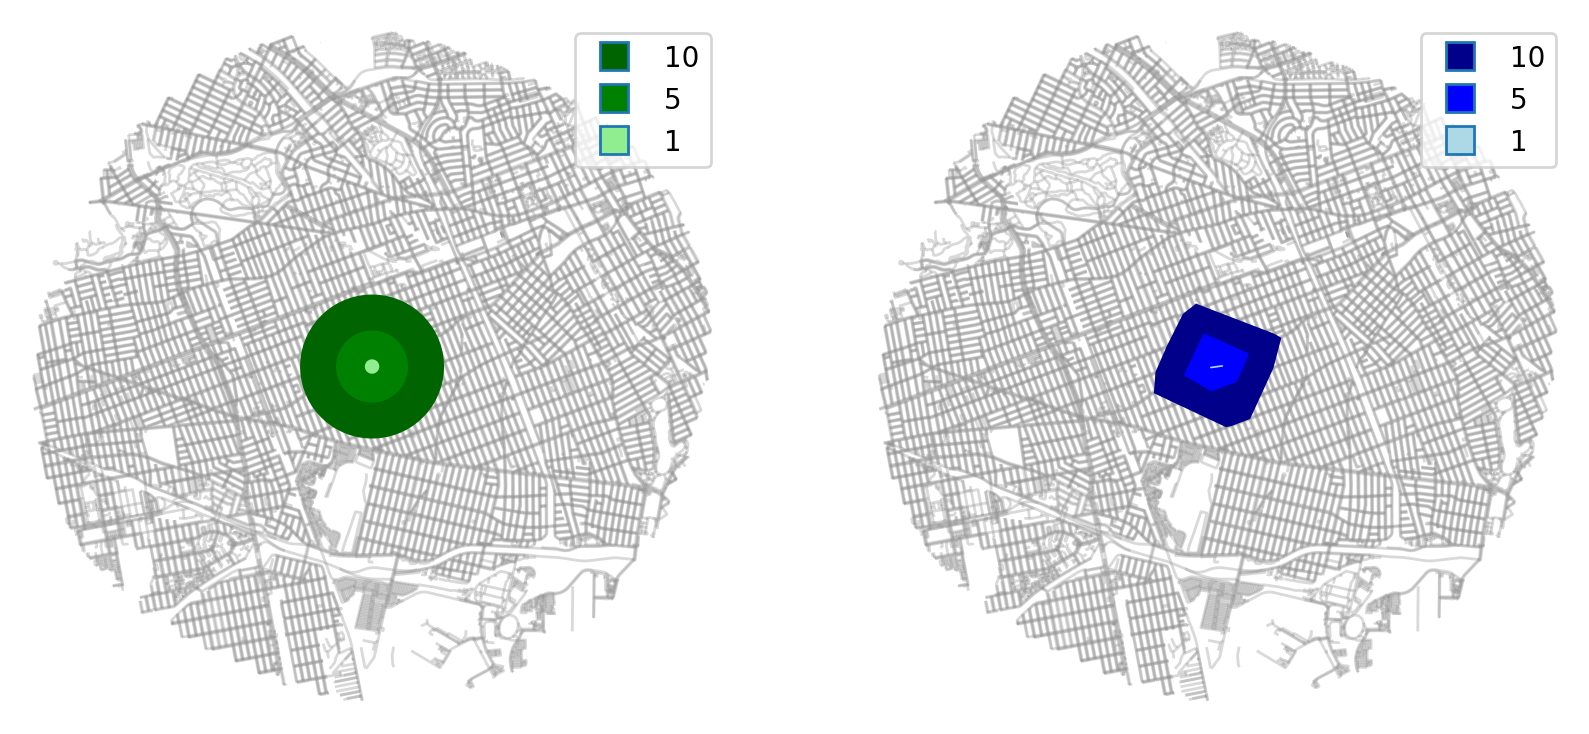

In [404]:
buffer_colors = ['darkgreen', 'green', 'lightgreen']
iso_colors = ['darkblue', 'blue', 'lightblue']

# plot the network then add isochrones
fig, axes = plt.subplots(1,2, figsize=(10,10))

ox.plot_graph(G_queens, ax=axes[0], show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='w')
ox.plot_graph(G_queens, ax=axes[1],  show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='w')

for trip_time, color1, color2 in zip(sorted(trip_times, reverse=True), buffer_colors, iso_colors):
    buffer_gdf[buffer_gdf['trip_time']==trip_time].plot(ax=axes[0], color=color1)
    isochrone_gdf[isochrone_gdf['trip_time']==trip_time].plot(ax=axes[1], color=color2)
    
for ax,color_list in zip(axes, [buffer_colors, iso_colors]):
    # adding the legend
    lines = [
        mlines.Line2D([0], [0], 
        linestyle="none", marker="s",
        markersize=10,
        markerfacecolor=color)
        for color in color_list
    ]
    labels = sorted(trip_times, reverse=True)
    ax.legend(lines, labels)
ax.set_axis_off()
plt.show()

Now, we'll plot the isochrones as buffers around the street grid

In [405]:
def create_edge_lines(G, nodes_gdf, n_fr, n_to):
    f = nodes_gdf.loc[n_fr].geometry
    t = nodes_gdf.loc[n_to].geometry
    return G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))

def make_iso_polys(node_list, G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = {x:[] for x in trip_times}
    for nd in tqdm(node_list):
        for trip_time in sorted(trip_times, reverse=True):
            subgraph = nx.ego_graph(G, nd, radius=trip_time, distance='time')
            node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
            nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
            nodes_gdf = nodes_gdf.set_index('id')

            edge_lines = []
            for n_fr, n_to in subgraph.edges():
                edge_lookup = create_edge_lines(G, nodes_gdf, n_fr, n_to)
                edge_lines.append(edge_lookup)
                

            n = nodes_gdf.buffer(node_buff).geometry
            e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
            all_gs = list(n) + list(e)
            new_iso = gpd.GeoSeries(all_gs).union_all()
            isochrone_polys[trip_time].append(new_iso)
    return isochrone_polys
#res = Parallel(n_jobs=4)(delayed(make_iso_polys)(nd, G) for nd in park_nodes[:10])
isochrone_polys = make_iso_polys(closest_node, G, edge_buff=25, node_buff=0, infill=True)

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


In [406]:
# create dataframe of buffer regions
isochrone_buffer_gdf_list = []
for trip_time in [5, 10]:
    isochrone_buffer_gdf_list += [gpd.GeoDataFrame(geometry=isochrone_polys[trip_time], crs=2263).assign(trip_time=trip_time)]
isochrone_buffer_gdf = pd.concat(isochrone_buffer_gdf_list)

/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_25502/288904484.py:5: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  isochrone_buffer_gdf[isochrone_buffer_gdf['trip_time']==trip_time].plot(ax=ax, color=color)


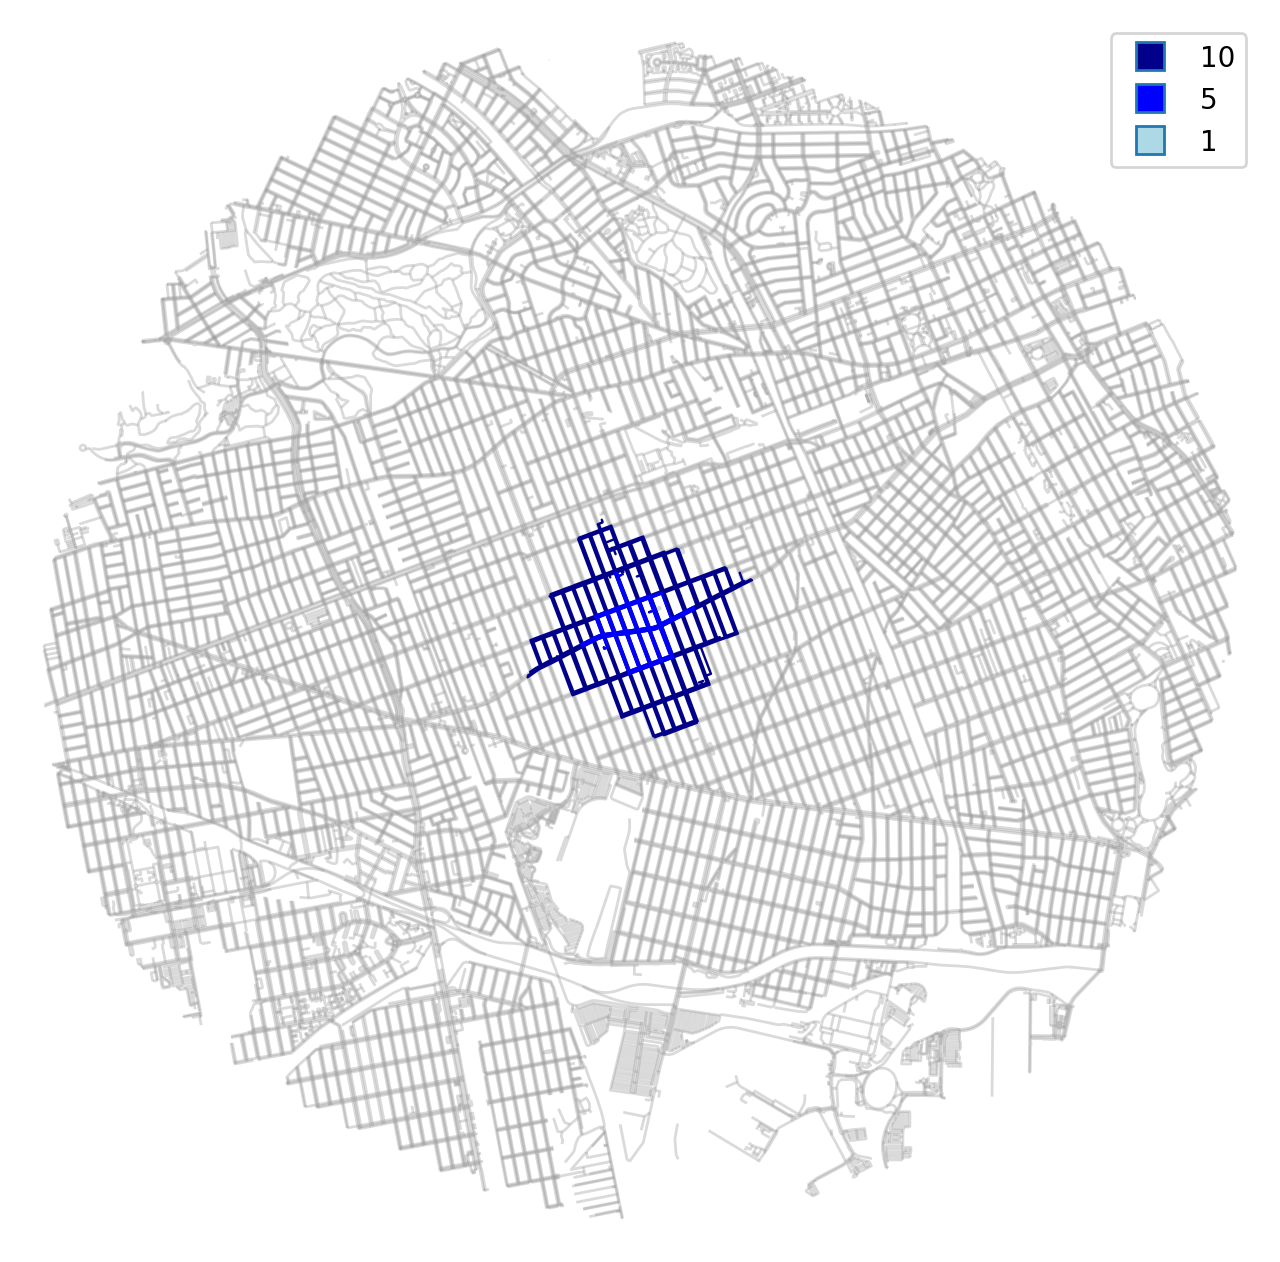

In [407]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G_queens, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='w')
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    isochrone_buffer_gdf[isochrone_buffer_gdf['trip_time']==trip_time].plot(ax=ax, color=color)

lines = [
    mlines.Line2D([0], [0], 
    linestyle="none", marker="s",
    markersize=10,
    markerfacecolor=color)
    for color in iso_colors
]
labels = sorted(trip_times, reverse=True)
ax.legend(lines, labels)
ax.set_axis_off()
plt.show()

## Now let's compare to biking and driving!

In [418]:
# download the bike network, this may take a few minutes
G_bike = ox.graph_from_place(place, network_type='bike')

# download the driving network, this may take a few minutes
G_drive = ox.graph_from_place(place, network_type='drive')

In [419]:
# need to project both!
G_bike = ox.project_graph(G_bike, to_crs=2263)
G_drive = ox.project_graph(G_drive, to_crs=2263)

In [420]:
# making the time values
mode_types = ['bike', 'drive']
graph_list = [G_bike, G_drive]

avg_feet_per_min = {
    'bike': 880,
    'drive': 2640
}

for mode_type, graph in zip(mode_types, graph_list):
    for u, v, k, data in graph.edges(data=True, keys=True):
        data['length_ft'] = data['length']*3.28084 # osmnx internal units are meters
        data['time'] = data['length_ft'] / (avg_feet_per_min[mode_type]) # divide by feet per minute

In [421]:
# make the isochrone polygons for bike and driving
# this time we'll iterate through mode
isochrone_polys_by_mode = {mode_type: {x:[] for x in trip_times} for mode_type in mode_types}
for mode_type, graph in zip(mode_types, graph_list):
    for node in tqdm(closest_node): # note: this loop can also take in a list of nodes
        for trip_time in sorted(trip_times, reverse=True):
            subgraph = nx.ego_graph(graph, node, radius=trip_time, distance='time')
            node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
            bounding_poly = gpd.GeoSeries(node_points).union_all().convex_hull
            isochrone_polys_by_mode[mode_type][trip_time].append(bounding_poly)
isochrone_polys_by_mode;

100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


In [428]:
# combine all of our isochrones into one dataframe
isochrone_gdf_mode_list = [pd.DataFrame.from_dict(isochrone_polys_by_mode[mode], orient='index').assign(mode_type=mode) for mode in mode_types]
isochrone_gdf_mode = pd.concat(isochrone_gdf_mode_list).reset_index().rename(columns={'index':'trip_time', 0:'geometry'})
isochrone_gdf_mode = isochrone_gdf_mode.set_geometry('geometry', crs=2263)
# add in walking isochrones too
isochrone_gdf_mode = pd.concat([isochrone_gdf_mode, isochrone_gdf.assign(mode_type='walk')]) 
isochrone_gdf_mode.head()

trip_time                                           geometry mode_type
0          1  POLYGON ((1031780.192 189123.995, 1032082.153 ...      bike
1          5  POLYGON ((1034151.285 185714.109, 1032615.828 ...      bike
2         10  POLYGON ((1034064.299 181858.814, 1031511.41 1...      bike
3          1  POLYGON ((1033102.027 186987.966, 1030130.518 ...     drive
4          5  POLYGON ((1032857.488 179051.507, 1028285.426 ...     drive

In [432]:
# define a dictionary with the colors for the isochrones
iso_colors_dict = {
    'walk': ['darkgreen', 'green', 'lightgreen'],
    'bike': ['darkblue', 'blue', 'lightblue'],
    'drive': ['darkred', 'red', 'orange']
}

# for plotting, create a subgraph that is just the street grid surrounding the pt
queens_nodes = gdf_nodes.clip(isochrone_gdf.buffer(5280*8)).index
G_queens = G.subgraph(queens_nodes)
G_queens;

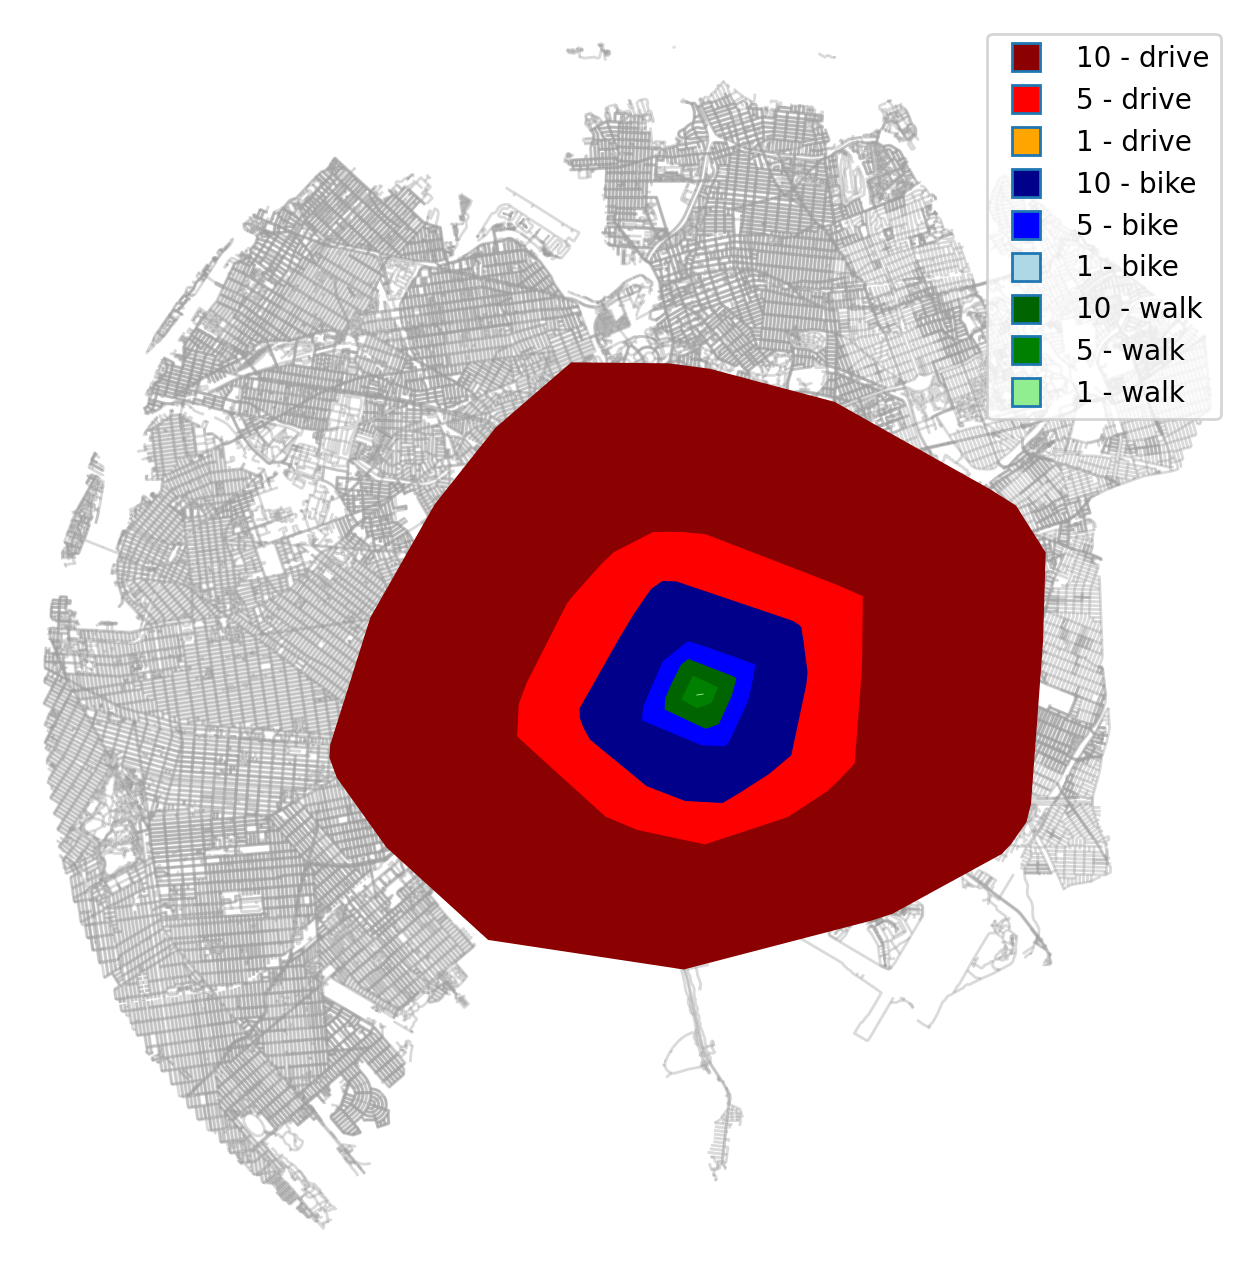

In [446]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G_queens, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='w')
for mode_type in ['drive', 'bike', 'walk']:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors_dict[mode_type]):
        isochrone_gdf_subset = isochrone_gdf_mode[(isochrone_gdf_mode['mode_type']==mode_type)\
            &(isochrone_gdf_mode['trip_time']==trip_time)]
        isochrone_gdf_subset.plot(ax=ax, color=color)

lines = [
    mlines.Line2D([0], [0], 
    linestyle="none", marker="s",
    markersize=10,
    markerfacecolor=color)
    for mode_type in ['drive', 'bike', 'walk'] for color in iso_colors_dict[mode_type]
]
labels = [str(i) + 'min - ' + mode_type for mode_type in ['drive', 'bike', 'walk'] for i in sorted(trip_times, reverse=True) ]
ax.legend(lines, labels)
ax.set_axis_off()
plt.show()